In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Xarxes convolucionals

L'objectiu d'avui és la creació d'una xarxa convolucional que obtengui **com a mínim igual resultat que la xarxa completament connectada implementada la setmana anterior però amb menys paràmetres**. Per poder realitzar comparacions directes emprarem el mateix conjunt de dades.

Com objectius secundaris tenim:

1. Aprenentatge de noves estratègies per evitar `overfitting`.
2. Us d'un nou optimitzador.
3. Visualització dels resultats dels filtres convolucionals.

Primer de tot, com sempre, les dades:


In [2]:
# Recordau: El label del dataset és l'índex de la llista labels. Cada posició de la llista és un codi ASCII. Podeu emprar la funció chr per fer la transformació

# Definim una seqüència (composició) de transformacions
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.1307,), (0.3081,)
        ),  # mitjana, desviacio tipica (precalculats)
    ]
)

# Descarregam un dataset ja integrat en la llibreria Pytorch:
train = datasets.EMNIST(
    "data", split="digits", train=True, download=True, transform=transform
)  ## Si acabau podeu fer proves amb el split "balanced"
test = datasets.EMNIST("data", split="digits", train=False, transform=transform)

In [3]:
train_batch_size = 64
test_batch_size = 100

# Transformam les dades en l'estructura necessaria per entrenar una xarxa
train_loader = torch.utils.data.DataLoader(train, train_batch_size)
test_loader = torch.utils.data.DataLoader(test, test_batch_size)

## Definició de la xarxa

### Feina a fer

1. Definir la primera xarxa convolucional. A continuació teniu una llista de les capes que podeu emprar:

-   `Conv2d`: Capa convolucional en 2 dimensions ([enllaç](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)). Com a paràmetres principals trobarem:

    -   in_channels: canals d'entrada.
    -   out_channels : canals de sortida.
    -   kernel_size: mida del filtre.
    -   stride: desplaçament del filtre. Típicament pren per valor 1.
    -   padding: ampliació de la imatge per evitar pèrdua de dimensionalitat.

-   `MaxPool2d`: Capa de max pooling ([enllaç](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)). Aquesta capa no té paràmetres entrenables. Però si:

    -   kernel_size: Mida del filtre del qual es seleccionarà el màxim.
    -   stride: desplaçament del filtre.

-   `Dropout`: Dropout és un mètode de regularització (evitar `overfitting`) que aproxima l'entrenament d'un gran nombre de xarxes neuronals amb diferents arquitectures en paral·lel. Durant l'entrenament, una part de les sortides de la capa s'ignoren aleatòriament o s'abandonen. Això té l'efecte de fer que la capa sembli i es tracti com una capa amb un nombre diferent de nodes i connectivitat a la capa anterior. En efecte, cada actualització d'una capa durant l'entrenament es realitza amb una vista diferent de la capa configurada. Hem d'especificar quines capes tenen `dropout` de manera individual. Té un únic paràmetre amb valor per defecte $p=0.5$ Els valors típics d'aquest paràmetre varien entre $0.5$ i $0.8$.

-   `Linear`

-   `ReLU`

2. Per posibilitar la visualització de les imatges passades per les capes convolucionals farem que funció `forward` tengui diverses sortides (diferents valors de `return`) un per cada capa convolucional de la xarxa.


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_1 = nn.Conv2d(
            in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1
        )
        self.conv_2 = nn.Conv2d(
            in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1
        )
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(7 * 7 * 16, 32)
        self.linear_2 = nn.Linear(32, 10)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self, x):
        layer_order = (
            ("conv", self.conv_1),
            ("pool", self.max_pool),
            ("conv", self.conv_2),
            ("pool", self.max_pool),
            ("flat", lambda x: torch.flatten(x, 1)),
            ("line", self.linear_1),
            ("line", self.linear_2),
            ("drop", self.dropout),
            ("relu", self.relu),
            ("sfmx", lambda x: F.log_softmax(x, dim=1)),
        )

        data = x.clone()

        data_outputs = []
        for name, layer in layer_order:
            data = layer(data)
            data_outputs.append((name, data.clone()))

        return data, data_outputs

## Entrenament

Aquesta part, per sort, no varia massa de la setmana anterior:

### Feina a fer

1. Modificar la sortida de la xarxa, ara retorna diversos valors, encara que aquí només us interessa un.


In [5]:
def train(
    model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True
):
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, _ = model(data)  # això no us funcionarà
        ## Aquesta setmana empram la cross_entropy com una funció
        loss = F.cross_entropy(output, target, reduction="sum")
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                    loss.item() / len(data),
                )
            )
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print("\nTrain set: Average loss: {:.4f}\n".format(loss_v))

    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            test_loss += F.cross_entropy(output, target, reduction="sum")
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

    return test_loss

A continuació definim els paràmetres d'entrenament i el bucle principal:

### Adam

Aquesta setmana introduirem un nou algorisme d'optimització anomenat `Adam`. Fins ara hem emprat el descens del gradient (`SGD`).

`Adam` és un algorisme d'optimització amplament emprat, tal com el descens del gradient, és iteratiu. A la literatura trobam arguments que indiquen que, tot i que Adam convergeix més ràpidament, SGD generalitza millor que Adam i, per tant, pot resultar en un rendiment final millor.

[Més info](https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008)

### Feina a fer:

1. Mostrar el nombre de paràmetres de la xarxa i compara-ho amb el nombre de paràmetres amb la xarxa de la setmana passada). Fes la teva xarxa més petita fins que el resultat decaigui.

```
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
```

2. Dibuixar els gràfics de la funció de pèrdua amb les dues funcions d'optimització que coneixem: comparar `SGD` amb `ADAM`.


In [6]:
use_cuda = False
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

epochs = 15
lr = 0.00001

model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

# Guardam el valor de peèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_loader, optimizer, epoch)
    test_l[epoch] = test(model, device, test_loader)

Train Epoch: 0 [0/240000 (0%)]	Loss: 146.837540, Average: 2.294337
Train Epoch: 0 [6400/240000 (3%)]	Loss: 145.073929, Average: 2.266780
Train Epoch: 0 [12800/240000 (5%)]	Loss: 144.125214, Average: 2.251956
Train Epoch: 0 [19200/240000 (8%)]	Loss: 145.489288, Average: 2.273270
Train Epoch: 0 [25600/240000 (11%)]	Loss: 141.731720, Average: 2.214558
Train Epoch: 0 [32000/240000 (13%)]	Loss: 143.571533, Average: 2.243305
Train Epoch: 0 [38400/240000 (16%)]	Loss: 137.490143, Average: 2.148283
Train Epoch: 0 [44800/240000 (19%)]	Loss: 137.147583, Average: 2.142931
Train Epoch: 0 [51200/240000 (21%)]	Loss: 125.747353, Average: 1.964802
Train Epoch: 0 [57600/240000 (24%)]	Loss: 130.292709, Average: 2.035824
Train Epoch: 0 [64000/240000 (27%)]	Loss: 128.073441, Average: 2.001148
Train Epoch: 0 [70400/240000 (29%)]	Loss: 128.211212, Average: 2.003300
Train Epoch: 0 [76800/240000 (32%)]	Loss: 114.848244, Average: 1.794504
Train Epoch: 0 [83200/240000 (35%)]	Loss: 115.304146, Average: 1.801627
T

## Resultats

Aquí visualitzarem els resultats d'aprenentatge de la xarxa.

### Feina a fer:

1. Fer una predicció del primer _batch_ del conjunt de _test_.
2. Visualitzar una imatge del _batch_ i posar la predicció i el groun truth com a títol de la imatge.
3. Visualitzar el resultat de la mateixa imatge passada per tots els filtres de la primera convolució de la vostra xarxa.
4. **Extra**: Fer la matriu de confusió de les 10 classes per poder entendre el que no estau fent bé (la xarxa no està fent bé).

A tenir en compte:

#### Subplots

Per fer graelles d'imatges podeu empar la funció `subplots`. Més [informació](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)

#### Device

Si heu emprat _GPU_ per accelerar el procés d'entrenament, els resultats que obtenim de la xarxa també seràn a la _GPU_. **Pytorch** proporciona la funció `cpu()` que retorna una còpia d'aquest objecte a la memòria de la CPU.

#### Detach

Per poder operar amb els resultats de la predicció emprarem la funció `detach` que retorna un nou Tensor "separat" del graf (xarxa) en curs.

Per tant per transformar el tensor que retorna la xarxa en un array de la lliberia _Numpy_ caldria fer el següent:

```
resultat_np = resultat.detach().numpy()
```

Si a més hem executat l'entrenament en _GPU_:

```
resultat_np = resultat.cpu().detach().numpy()
```


In [ ]:
def show_images_with_pred(images, labels, predictions):
    model.eval()

    n_images = len(images)
    fig, axs = plt.subplots(
        int(n_images**0.5),
        int(n_images**0.5),
        figsize=(n_images // 4, n_images // 4),
    )
    axs = axs.flatten()

    for image, label, predict, ax in zip(images, labels, predictions, axs):
        ax.imshow(image.reshape(*image.shape[-2::]))
        ax.set_title(f"Label: {label}, Prediction: {predict}")
        ax.axis("off")
    plt.show()

data, labels = next(iter(test_loader))
model.eval()
predictions, layers = model(data)
predictions = np.argmax(predictions.detach().cpu().numpy(), axis=1)

show_images_with_pred(data, labels, predictions)

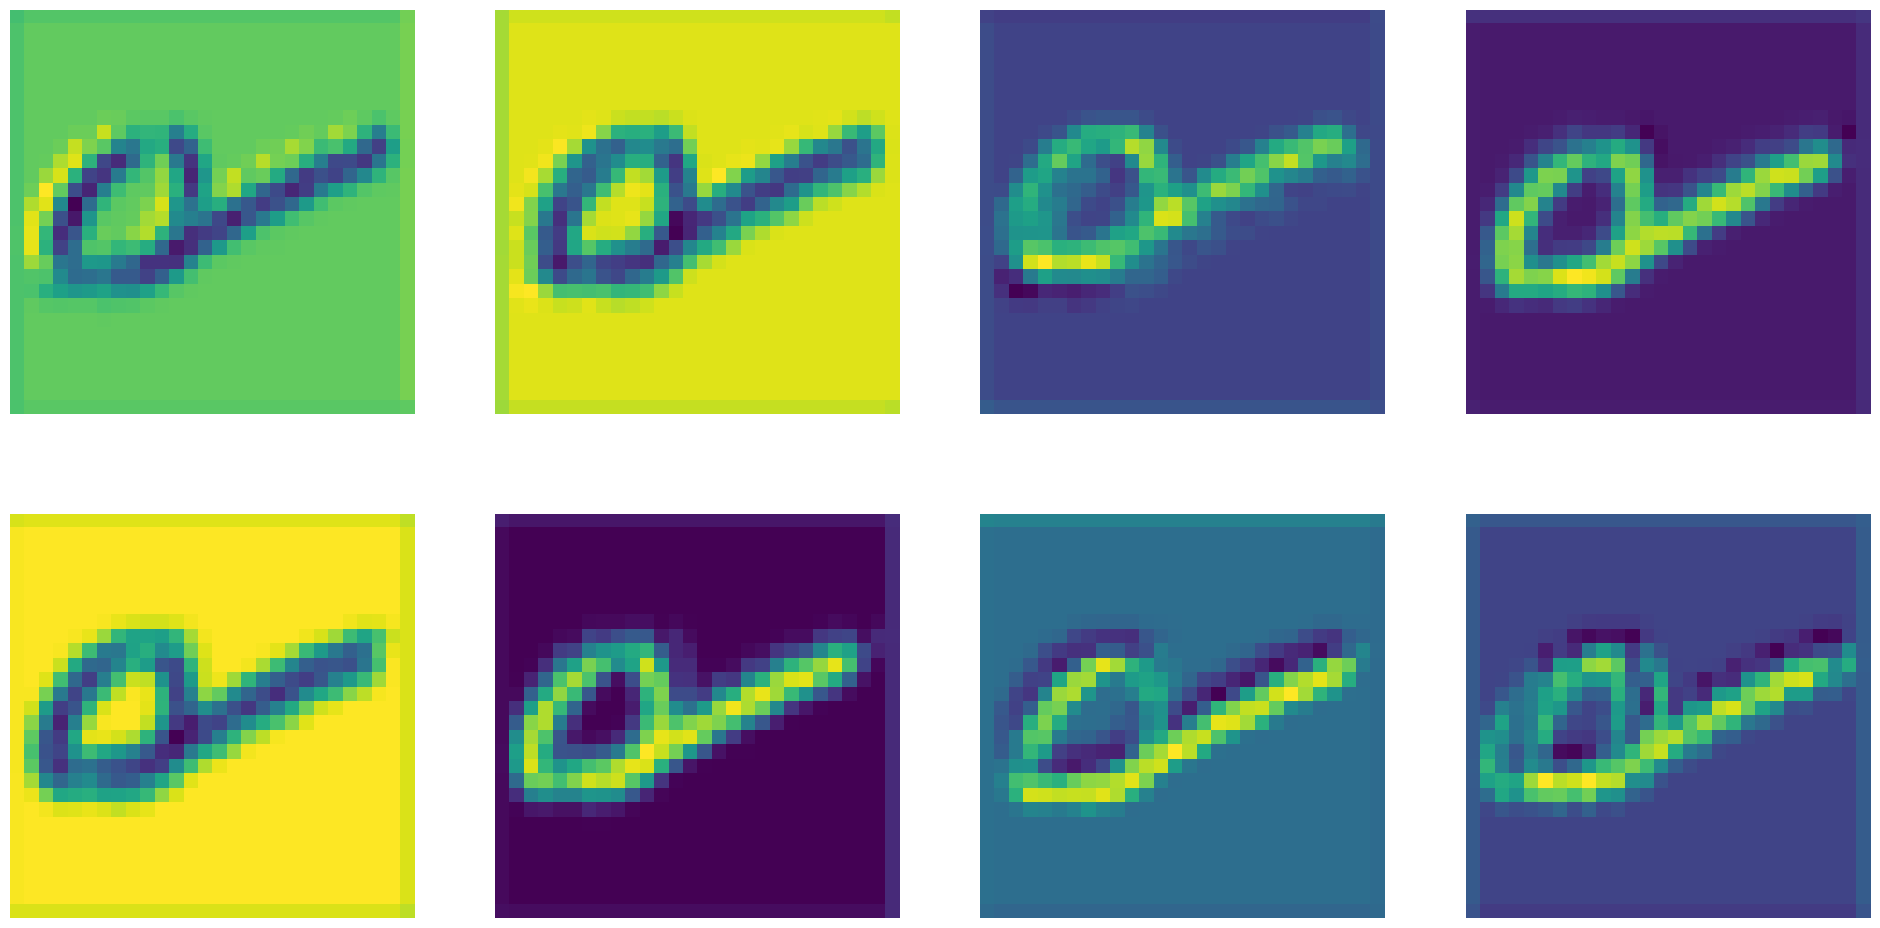

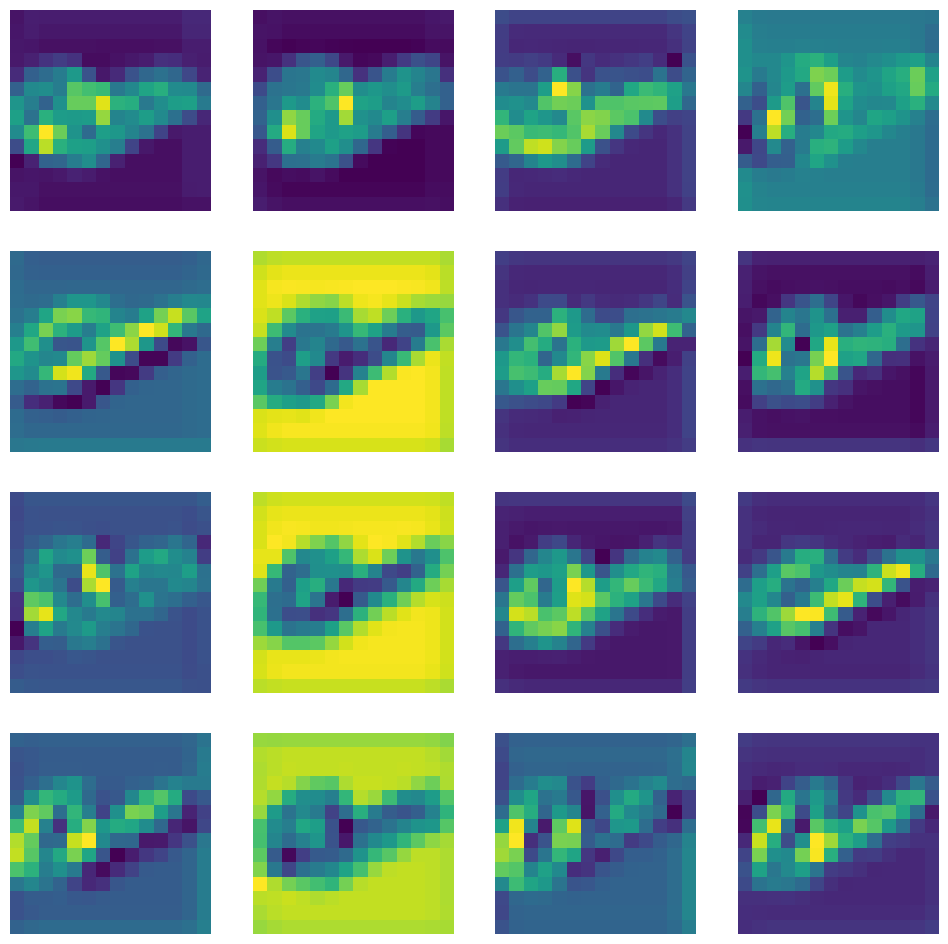

In [50]:
# select convolution layers
conv_layers = [x[1] for x in filter(lambda x: x[0] == "conv", layers)]


fig, axs = plt.subplots(2, 4, figsize=(24,12))
axs = axs.flatten()

for idx, ax in enumerate(axs):
    ax.imshow(conv_layers[0].detach().cpu().numpy()[1, idx, :, :])
    ax.axis("off")

plt.show()

fig, axs = plt.subplots(4, 4, figsize=(12,12))
axs = axs.flatten()

for idx, ax in enumerate(axs):
    ax.imshow(conv_layers[1].detach().cpu().numpy()[1, idx, :, :])
    ax.axis("off")

plt.show()

In [52]:
def predict(model, data_loader):
    model.eval()

    truth = []
    predictions = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            predictions.extend(target.tolist())
            output, _ = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            truth.extend(torch.flatten(pred.cpu()).tolist())

    return truth, predictions

cm = confusion_matrix(*predict(model, next(iter(test_loader))))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Prediccions')
plt.ylabel('Ground Truth')
plt.show()